# RWによる同心 正方形の容量計算  テスト３
開始点をランダムに決定
RW毎に電荷への寄与度を計算し累積したものをRW数で割ることで統計的に容量を算出する。

100%|██████████| 3200/3200 [01:11<00:00, 45.03it/s]



=== Calculation Results ===
Calculated Capacitance : 5.926e-11 F/m
Inner Hit Probability : 0.920
Charge contribution   : 7.437e-10 C/hit
Average Steps per Walk: 26.9
Total Random Walks    : 320000
Computation Time      : 71.06 seconds



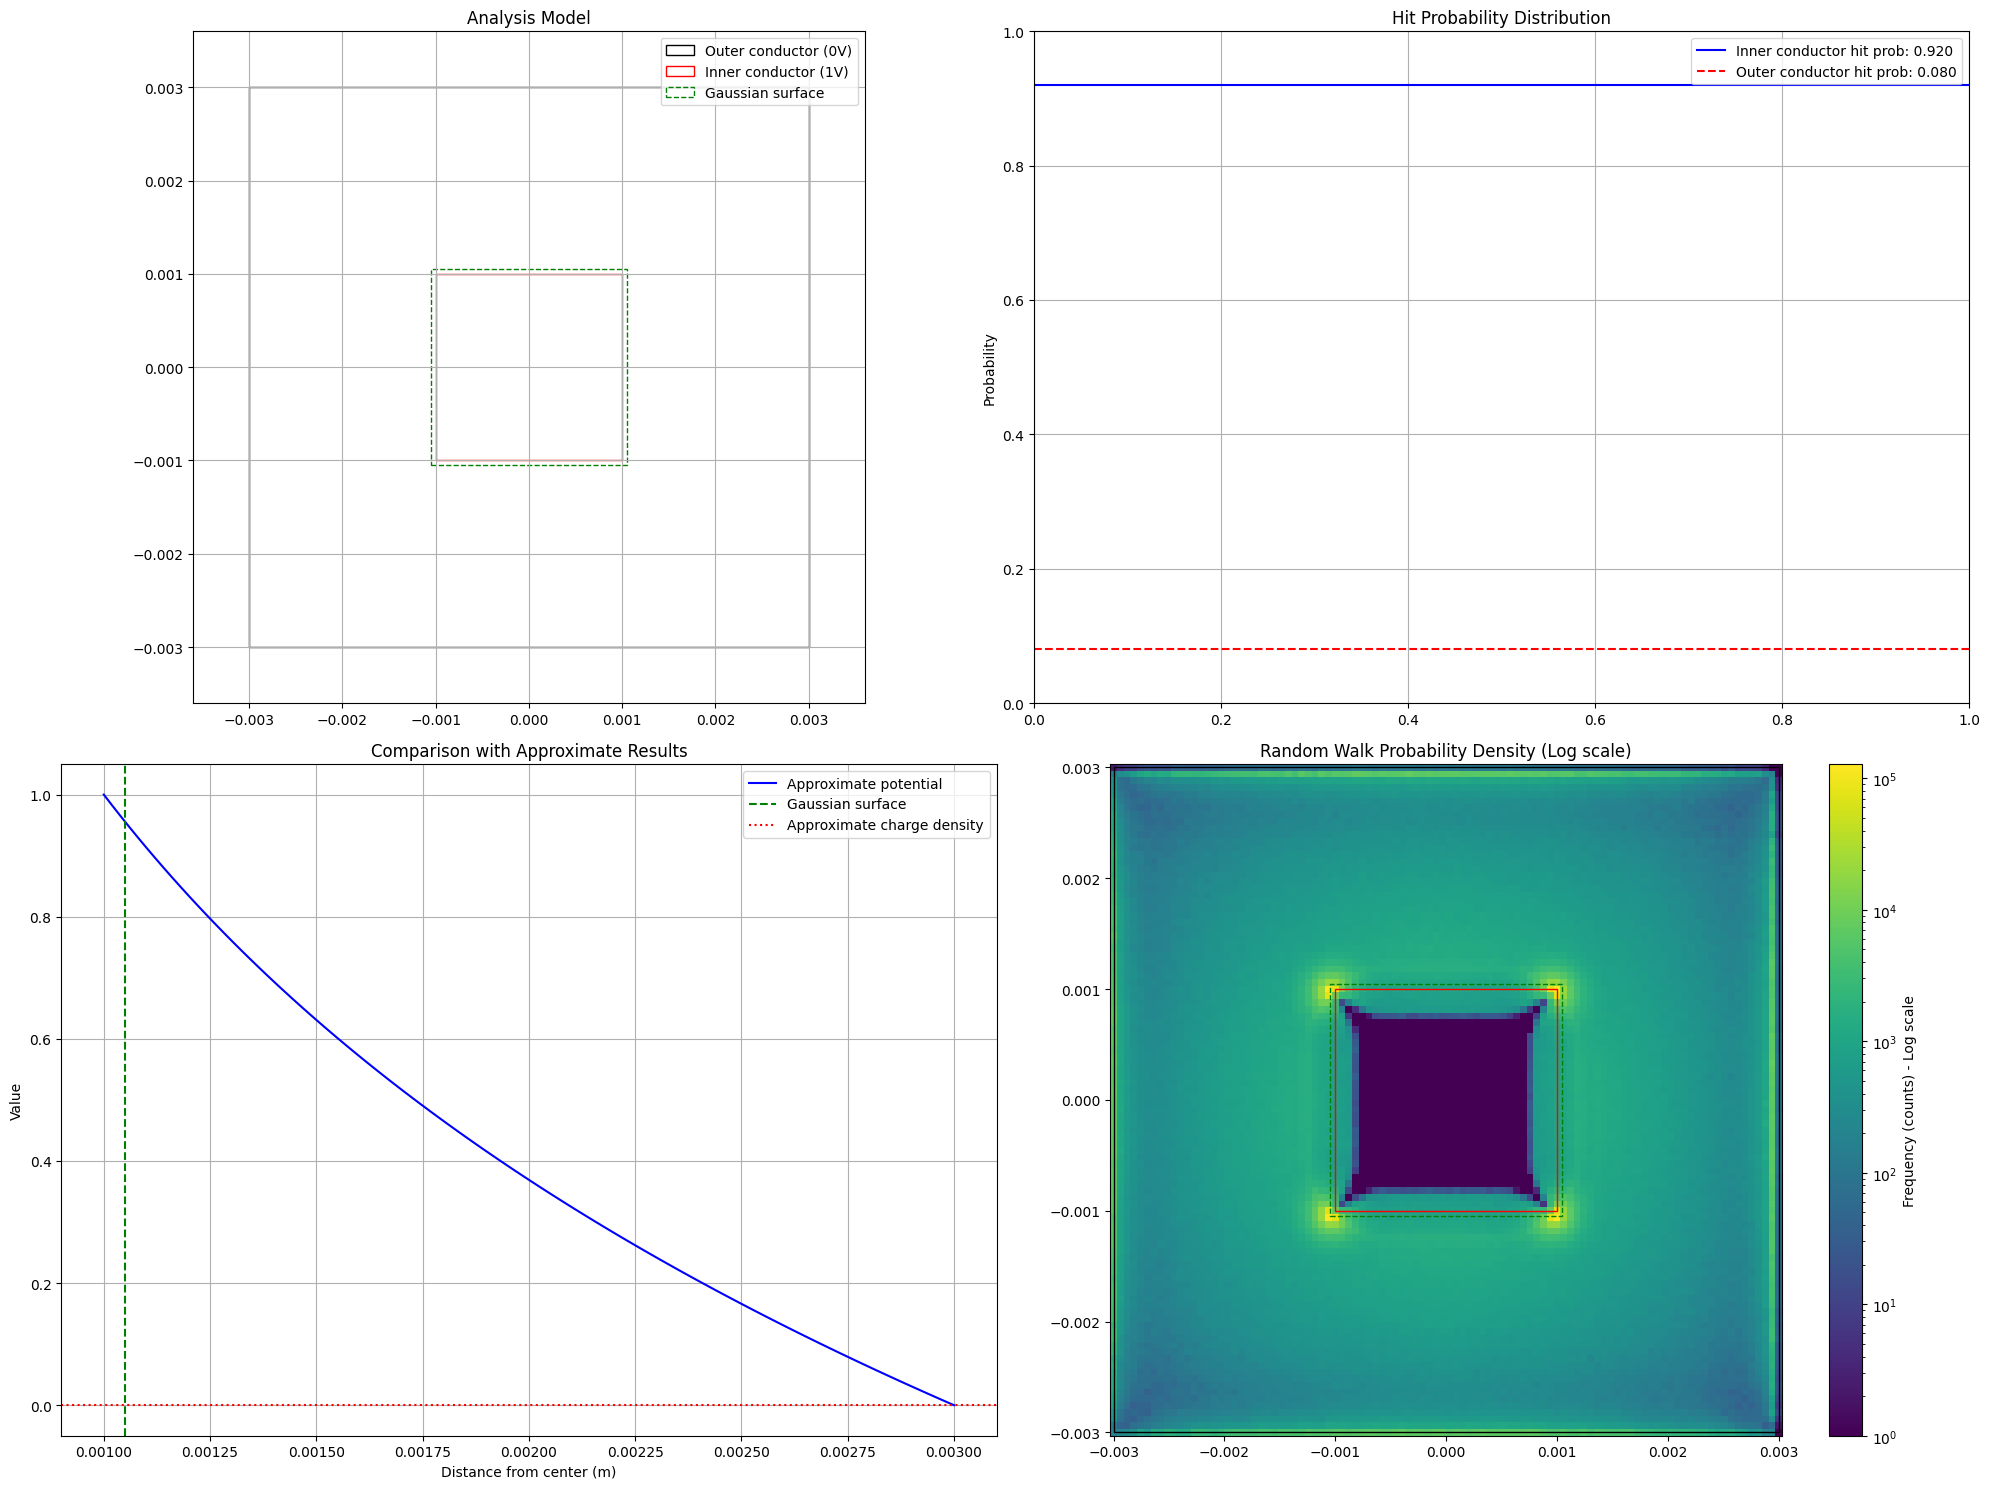

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict
from tqdm import tqdm
from matplotlib.patches import Rectangle
from matplotlib.colors import LogNorm
import time

class SquareCapacitanceCalculator:
    """二重正方形構造の容量計算クラス - 1回のRWごとの電荷寄与を計算"""
    
    def __init__(
        self,
        inner_side: float,
        outer_side: float,
        gaussian_surface_ratio: float,
        num_walks: int,
        base_step_size: float,
        mesh_size: int = 50,
        batch_size: int = 100
    ):
        self.inner_side = inner_side
        self.outer_side = outer_side
        self.gaussian_side = inner_side * gaussian_surface_ratio
        self.num_walks = num_walks
        self.base_step_size = base_step_size
        self.epsilon0 = 8.854e-12
        self.batch_size = batch_size
        
        # メッシュの設定
        self.mesh_size = mesh_size
        self.x_mesh = np.linspace(-outer_side/2, outer_side/2, mesh_size)
        self.y_mesh = np.linspace(-outer_side/2, outer_side/2, mesh_size)
        self.density_map = np.zeros((mesh_size, mesh_size))
        self.mesh_scale = (mesh_size - 1) / outer_side
        self.total_steps = 0

        # 電荷寄与度の計算に必要な定数を前計算
        self.d = self.gaussian_side - self.inner_side  # ガウス面までの距離
        self.gaussian_perimeter = 4 * self.gaussian_side  # ガウス面の全周長
        self.charge_factor = self.epsilon0 * self.gaussian_perimeter / self.d
     
    def generate_random_start_point(self) -> np.ndarray:
        """ガウス面（正方形）上のランダムな開始点を1つ生成 - 改良版
        角付近での電場の集中を考慮した分布を使用
        """
        # 全周の長さに沿った一様乱数を生成
        perimeter = 4 * self.gaussian_side
        position = np.random.uniform(0, perimeter)
        half_side = self.gaussian_side / 2
        
        # 位置から座標を計算
        if position < self.gaussian_side:  # 下辺
            return np.array([position - half_side, -half_side])
        elif position < 2 * self.gaussian_side:  # 右辺
            return np.array([half_side, position - 3*half_side])
        elif position < 3 * self.gaussian_side:  # 上辺
            return np.array([5*half_side - position, half_side])
        else:  # 左辺
            return np.array([-half_side, 7*half_side - position])
        

    def update_density_map(self, positions: np.ndarray):
        """密度マップの更新"""
        indices_x = ((positions[:, 0] + self.outer_side/2) * self.mesh_scale).astype(int)
        indices_y = ((positions[:, 1] + self.outer_side/2) * self.mesh_scale).astype(int)
        
        mask = (indices_x >= 0) & (indices_x < self.mesh_size) & \
               (indices_y >= 0) & (indices_y < self.mesh_size)
        
        for x, y in zip(indices_x[mask], indices_y[mask]):
            self.density_map[y, x] += 1

    def is_inside_square(self, positions: np.ndarray, side_length: float) -> np.ndarray:
        """指定された正方形の内側にあるかどうかを判定"""
        half_side = side_length / 2
        return (np.abs(positions[:, 0]) <= half_side) & (np.abs(positions[:, 1]) <= half_side)
    

    def calculate_distance_to_boundary(self, positions: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """各点から内側と外側の境界までの距離を計算"""
        # 各点から中心までの距離を計算
        abs_x = np.abs(positions[:, 0])
        abs_y = np.abs(positions[:, 1])
        
        # 内側の境界までの距離
        dist_to_inner_x = np.abs(self.inner_side/2 - abs_x)
        dist_to_inner_y = np.abs(self.inner_side/2 - abs_y)
        # L1ノルムベースの距離計算
        dist_to_inner = np.where(
            (abs_x <= self.inner_side/2) & (abs_y <= self.inner_side/2),
            np.minimum(dist_to_inner_x, dist_to_inner_y),
            np.sqrt(dist_to_inner_x**2 + dist_to_inner_y**2)
        )
        
        # 外側の境界までの距離
        dist_to_outer_x = np.abs(self.outer_side/2 - abs_x)
        dist_to_outer_y = np.abs(self.outer_side/2 - abs_y)
        dist_to_outer = np.where(
            (abs_x <= self.outer_side/2) & (abs_y <= self.outer_side/2),
            np.minimum(dist_to_outer_x, dist_to_outer_y),
            np.sqrt(dist_to_outer_x**2 + dist_to_outer_y**2)
        )
        
        return dist_to_inner, dist_to_outer

    def random_walk_batch(self) -> Tuple[np.ndarray, int]:
        """バッチ処理によるランダムウォーク（修正版）"""
        start_points = np.array([self.generate_random_start_point() for _ in range(self.batch_size)])
        positions = start_points.copy()
        total_steps = 0
        active = np.ones(self.batch_size, dtype=bool)
        hit_results = np.zeros(self.batch_size, dtype=int)
        
        while active.any():
            n_active = active.sum()
            active_positions = positions[active]
            
            # 境界までの距離を計算（修正版）
            dist_to_inner, dist_to_outer = self.calculate_distance_to_boundary(active_positions)
            min_dist = np.minimum(dist_to_inner, dist_to_outer)
            
            # ステップサイズの計算
            base_step = self.base_step_size * (self.outer_side - self.inner_side)
            step_sizes = np.minimum(base_step, min_dist * 0.5)
            step_sizes = np.maximum(step_sizes, 1e-6)
            
            # ランダムな方向への移動
            angles = np.random.uniform(0, 2*np.pi, n_active)
            moves = np.column_stack((
                step_sizes * np.cos(angles),
                step_sizes * np.sin(angles)
            ))
            
            positions[active] += moves
            self.update_density_map(positions[active])
            
            # 終了判定
            inner_hit = self.is_inside_square(positions[active], self.inner_side)
            outer_hit = ~self.is_inside_square(positions[active], self.outer_side)
            
            active_indices = np.where(active)[0]
            hit_results[active_indices[inner_hit]] = 1
            
            active[active_indices[inner_hit | outer_hit]] = False
            total_steps += n_active

        return hit_results, total_steps

    def calculate_capacitance(self) -> Tuple[float, Dict]:
        """容量を計算"""
        start_time = time.time()
        self.density_map.fill(0)
        self.total_steps = 0
        
        total_charge = 0
        all_hit_results = []
        
        for batch in tqdm(range(0, self.num_walks, self.batch_size)):
            batch_size = min(self.batch_size, self.num_walks - batch)
            
            if batch_size != self.batch_size:
                temp_batch_size = self.batch_size
                self.batch_size = batch_size
                hit_results, steps = self.random_walk_batch()
                self.batch_size = temp_batch_size
            else:
                hit_results, steps = self.random_walk_batch()
            
            batch_charge = np.sum(~hit_results.astype(bool)) * self.charge_factor
            total_charge += batch_charge
            
            all_hit_results.extend(hit_results)
            self.total_steps += steps
        
        C = total_charge / self.num_walks
        
        # 正方形キャパシタの理論値（近似式）
        # 注：この式は完全な理論値ではなく、数値計算による近似式です
        C_theoretical = 8 * self.epsilon0 * self.inner_side / (np.pi * np.log(self.outer_side / self.inner_side))
        
        computation_time = time.time() - start_time
        
        results = {
            'hit_results': np.array(all_hit_results),
            'inner_hit_probability': np.mean(all_hit_results),
            'theoretical_capacitance': C_theoretical,
            'relative_error': abs(C - C_theoretical) / C_theoretical * 100,
            'density_map': self.density_map,
            'max_frequency': np.max(self.density_map),
            'average_steps': self.total_steps / self.num_walks,
            'computation_time': computation_time,
            'charge_contribution': self.charge_factor
        }

        return C, results
    
    def plot_all_results(self, results: Dict):
        """結果の可視化"""
        fig = plt.figure(figsize=(20, 15))
        
        # 1. 解析モデル図
        ax1 = fig.add_subplot(221)
        self._plot_model(ax1)
        
        # 2. ヒット確率の分布
        ax2 = fig.add_subplot(222)
        self._plot_hit_probability(ax2, results)
        
        # 3. 理論値との比較
        ax3 = fig.add_subplot(223)
        self._plot_theoretical_comparison(ax3, results)
        
        # 4. ランダムウォーク密度分布
        ax4 = fig.add_subplot(224)
        self._plot_walk_density(ax4, results)
        
        plt.tight_layout()
        plt.show()

    def _plot_model(self, ax):
        """解析モデル図の描画"""
        outer = Rectangle((-self.outer_side/2, -self.outer_side/2), self.outer_side, self.outer_side,
                         fill=False, color='black', label='Outer conductor (0V)')
        inner = Rectangle((-self.inner_side/2, -self.inner_side/2), self.inner_side, self.inner_side,
                         fill=False, color='red', label='Inner conductor (1V)')
        gaussian = Rectangle((-self.gaussian_side/2, -self.gaussian_side/2), self.gaussian_side, self.gaussian_side,
                           fill=False, color='green', linestyle='--', label='Gaussian surface')
        
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.add_patch(gaussian)
        
        ax.set_aspect('equal')
        ax.grid(True)
        ax.legend()
        ax.set_title('Analysis Model')
        
        margin = 0.2
        ax.set_xlim(-self.outer_side/2*(1+margin), self.outer_side/2*(1+margin))
        ax.set_ylim(-self.outer_side/2*(1+margin), self.outer_side/2*(1+margin))

    def _plot_hit_probability(self, ax, results):
        """ヒット確率分布のプロット"""
        ax.axhline(y=results['inner_hit_probability'], color='blue', linestyle='-', 
                  label=f'Inner conductor hit prob: {results["inner_hit_probability"]:.3f}')
        ax.axhline(y=1-results['inner_hit_probability'], color='red', linestyle='--', 
                  label=f'Outer conductor hit prob: {1-results["inner_hit_probability"]:.3f}')
        
        ax.set_title('Hit Probability Distribution')
        ax.set_ylabel('Probability')
        ax.grid(True)
        ax.legend()

    def _plot_theoretical_comparison(self, ax, results):
        """理論値との比較プロット"""
        # 簡易的な電位分布（正確な解析解ではない）
        x = np.linspace(self.inner_side/2, self.outer_side/2, 100)
        V_approx = 1.0 - np.log(x/(self.inner_side/2)) / np.log(self.outer_side/self.inner_side)
        
        ax.plot(x, V_approx, 'b-', label='Approximate potential')
        ax.axvline(x=self.gaussian_side/2, color='g', linestyle='--', label='Gaussian surface')
        
        C = results['theoretical_capacitance']
        charge = C  # V=1なので、Q=CV=C
        charge_density_approx = charge / (4 * self.gaussian_side)
        ax.axhline(y=charge_density_approx, color='r', linestyle=':', 
                  label='Approximate charge density')
        
        ax.set_title('Comparison with Approximate Results')
        ax.set_xlabel('Distance from center (m)')
        ax.set_ylabel('Value')
        ax.grid(True)
        ax.legend()

    def _plot_walk_density(self, ax, results):
        """対数スケールでのランダムウォーク確率密度分布プロット"""
        min_nonzero = np.min(results['density_map'][results['density_map'] > 0])
        plot_data = results['density_map'].copy()
        plot_data[plot_data == 0] = min_nonzero / 2
        
        im = ax.pcolormesh(self.x_mesh, self.y_mesh, plot_data,
                          norm=LogNorm(vmin=min_nonzero, vmax=np.max(plot_data)),
                          cmap='viridis')
        
        # 正方形の境界を追加
        outer = Rectangle((-self.outer_side/2, -self.outer_side/2), self.outer_side, self.outer_side,
                         fill=False, color='black')
        inner = Rectangle((-self.inner_side/2, -self.inner_side/2), self.inner_side, self.inner_side,
                         fill=False, color='red')
        gaussian = Rectangle((-self.gaussian_side/2, -self.gaussian_side/2), self.gaussian_side, self.gaussian_side,
                           fill=False, color='green', linestyle='--')
        
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.add_patch(gaussian)
        
        plt.colorbar(im, ax=ax, label='Frequency (counts) - Log scale')
        
        ax.set_aspect('equal')
        ax.set_title('Random Walk Probability Density (Log scale)')

if __name__ == "__main__":
    # パラメータ設定
    params = {
        'inner_side': 0.002,         # 内側正方形の一辺 [m]
        'outer_side': 0.006,         # 外側正方形の一辺 [m]
        'gaussian_surface_ratio': 1.05, # ガウス面の位置（内側正方形との比）
        'num_walks': 320000,          # 総ランダムウォーク回数
        'base_step_size': 1/20,      # 基本ステップサイズ
        'mesh_size': 100,            # メッシュサイズ
        'batch_size': 100            # バッチサイズ
    }

    # 計算実行
    calculator = SquareCapacitanceCalculator(**params)
    C, results = calculator.calculate_capacitance()

    # 結果表示
    print("\n=== Calculation Results ===")
    print(f"Calculated Capacitance : {C:.3e} F/m")
    print(f"Inner Hit Probability : {results['inner_hit_probability']:.3f}")
    print(f"Charge contribution   : {results['charge_contribution']:.3e} C/hit")
    print(f"Average Steps per Walk: {results['average_steps']:.1f}")
    print(f"Total Random Walks    : {params['num_walks']}")
    print(f"Computation Time      : {results['computation_time']:.2f} seconds")
    print("==========================\n")

    # 結果のプロット
    calculator.plot_all_results(results)